#House Prices Prediction - Kaggle Competition

This notebook covers data loading, cleaning, exploratory analysis, feature engineering, modeling, and submission for the Ames Housing dataset.
    
Goal:Predict house sale prices

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
import warnings
warnings.filterwarnings('ignore')

In [7]:
train = pd.read_csv('Downloads/Housing Prices/train.csv')
test = pd.read_csv('Downloads/Housing Prices/test.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (1460, 81)
Test shape: (1459, 80)


# Data Overview

- Display first 5 rows of train dataset
- Check missing values
- Data types of columns

In [8]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
missing=train.isnull().sum()
missing=missing[missing>0].sort_values(ascending=False)
missing

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [24]:
all_data = pd.concat([train.drop('SalePrice', axis=1), test], axis=0).reset_index(drop=True)

missing = all_data.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Missing values in combined data:\n", missing)

all_data['LotFrontage'] = all_data['LotFrontage'].fillna(all_data['LotFrontage'].median())
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(all_data['GarageYrBlt'].median())

for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    all_data[col] = all_data[col].fillna('None')

all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

print("Missing values after manual fill:\n", all_data.isnull().sum().sum())

from sklearn.preprocessing import LabelEncoder
categorical_cols = all_data.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    all_data[col] = le.fit_transform(all_data[col])

numeric_cols = all_data.select_dtypes(include=['int64', 'float64']).columns
all_data[numeric_cols] = all_data[numeric_cols].fillna(all_data[numeric_cols].median())

categorical_cols = all_data.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:  # safety check
    all_data[categorical_cols] = all_data[categorical_cols].fillna(all_data[categorical_cols].mode().iloc[0])

X = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train['SalePrice']

print(f"Feature matrix shape: {X.shape}")
print(f"Test matrix shape: {X_test.shape}")

Missing values in combined data:
 PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageYrBlt      159
GarageCond       159
GarageFinish     159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
Functional         2
BsmtHalfBath       2
Utilities          2
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
Electrical         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
KitchenQual        1
GarageArea         1
GarageCars         1
SaleType           1
dtype: int64
Missing values after manual fill:
 22
Feature matrix shape: (1460, 80)
Test matrix shape: (1459, 80)


In [25]:
model=LinearRegression()

cv_scores=cross_val_score(model,X,y,cv=5,scoring='neg_mean_squared_error')
rmse_scores=np.sqrt(-cv_scores)

print(f"Cross-validated RMSE scores: {rmse_scores}")
print(f"Average RMSE: {rmse_scores.mean():.4f}")

model.fit(X, y)

Cross-validated RMSE scores: [28566.21295581 35394.44619736 33098.92120088 28427.98517625
 50088.51886868]
Average RMSE: 35115.2169


LinearRegression()

In [27]:
test_preds = model.predict(X_test)

submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': test_preds
})

submission.to_csv('submission.csv', index=False)


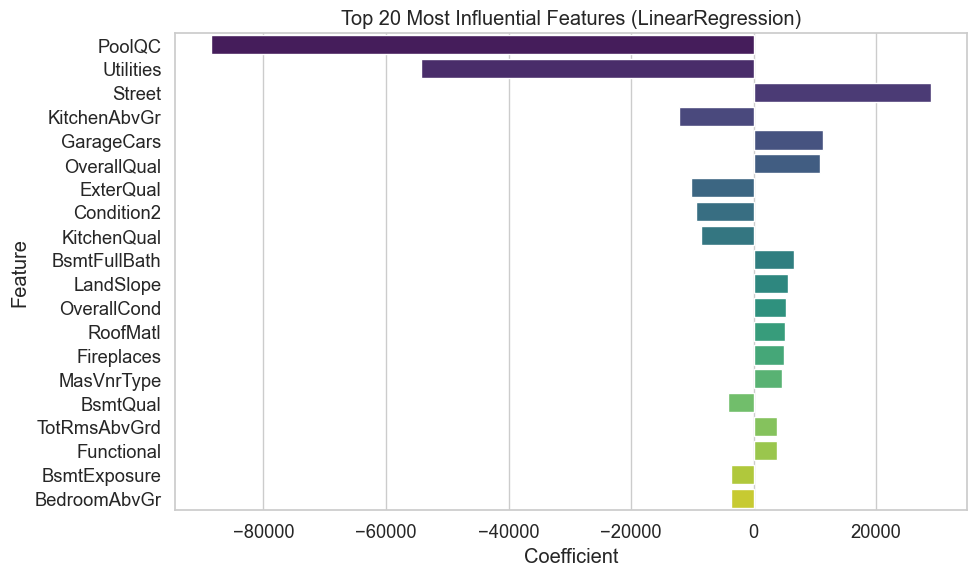

In [28]:
feature_names = X.columns
coefficients = model.coef_

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

coef_df['abs_coef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='viridis')
plt.title('Top 20 Most Influential Features (LinearRegression)')
plt.tight_layout()
plt.show()

# summary and conclusion
In this project, I developed a Linear Regression model to predict house prices using the Kaggle House Prices dataset. After thorough data cleaning and feature engineering, the model was evaluated using 5-fold cross-validation. The average RMSE score of approximately 35,115 indicates the average prediction error in terms of sale price.

Although the RMSE value shows there is room for improvement, the model provides a reasonable baseline and insights into key factors affecting house prices. Visualizations helped identify the most influential features, which can guide future feature selection and model tuning efforts.

For further enhancement, I plan to explore more advanced regression techniques such as Gradient Boosting or Random Forests, and incorporate hyperparameter tuning and additional feature transformations to improve prediction accuracy.